In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [6]:
import yfinance as yf

df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
df = df[['Close']]

C:\Users\Marcos Simoneli\AppData\Local\Temp\ipykernel_9116\3896639056.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


In [7]:
# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [8]:
# Função para criar janelas de dados sequenciais
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [9]:
# Dividir dados em treino e validação (80% treino, 20% validação)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # pegar os 60 passos anteriores

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [15]:
print(X_test)

[[0.88249214 0.84323642 0.83699108 ... 0.79248051 0.76774724 0.74658702]
 [0.84323642 0.83699108 0.8292406  ... 0.76774724 0.74658702 0.72363993]
 [0.83699108 0.8292406  0.84730697 ... 0.74658702 0.72363993 0.74859676]
 ...
 [0.86132516 0.85372144 0.86081839 ... 0.98065543 0.97456466 0.97146257]
 [0.85372144 0.86081839 0.86785882 ... 0.97456466 0.97146257 0.97202656]
 [0.86081839 0.86785882 0.88239037 ... 0.97146257 0.97202656 0.97445162]]


In [16]:
# Remodelar para LSTM [amostras, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [17]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\Marcos Simoneli\OneDrive\Documentos\Machine Learning\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0172 - val_loss: 9.9708e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.4845e-04 - val_loss: 0.0015
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.8032e-04 - val_loss: 0.0026
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.4598e-04 - val_loss: 0.0014
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.4310e-04 - val_loss: 9.0031e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.9026e-04 - val_loss: 0.0028
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.3046e-04 - val_loss: 0.0011
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.8853e-04 - val_loss: 9.2240e-04
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.6409e-04 - val_loss: 7.2519e-04
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.2626e-04 - val_loss: 0.0047
Epoch 12/20

In [19]:
# Métricas
mae = mean_absolute_error(real_prices, predictions)
rmse = np.sqrt(mean_squared_error(real_prices, predictions))
mape = mean_absolute_percentage_error(real_prices, predictions)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")

MAE: 4.7035
RMSE: 5.5599
MAPE: 2.9303%


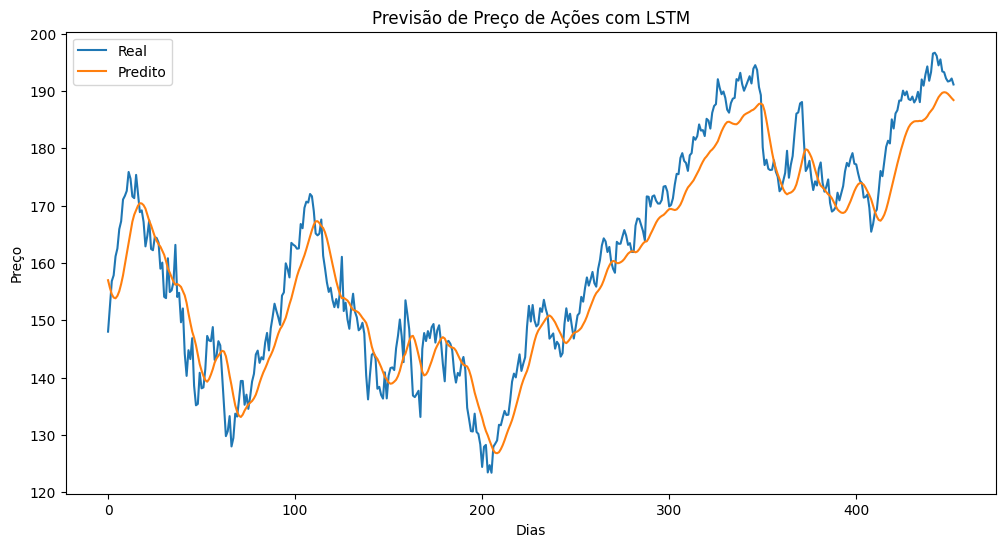

In [20]:
plt.figure(figsize=(12,6))
plt.plot(real_prices, label='Real')
plt.plot(predictions, label='Predito')
plt.title('Previsão de Preço de Ações com LSTM')
plt.xlabel('Dias')
plt.ylabel('Preço')
plt.legend()
plt.show()

print("")

model.save('modelo_lstm_acao.h5')